---------

# Linear Regression

## Todays Key Topics
- **Minimize Squared Error**
- **Distributional Assumptions for Linear Regression**
- **Statistical Claims (Hypotheses) are required for Regression Coefficients & Predictions**
- **Check validity of Linear Regressions (LR) assumptions**
- **Looking at the residuals**
    - Are they Homoscedastic?
    - Are they Normal?
- **What is a multi-collinearity?**
- **Data Transformations so that it is more linear and homescedastic**
- **Interpreting Regression COefficients for Categorical Features**

#### If there is one thing you come away with today, it will be how to plot the Residuals


### Exact Linear Relationship

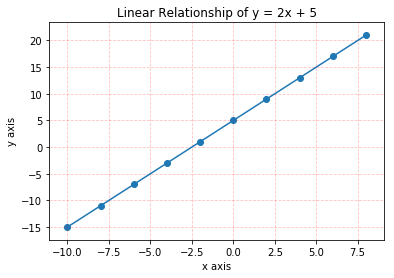

In [2]:
#Import the libraries we are using today
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42)


# Create the vectors for plotting
x = np.arange(-10,10,2)
y = 2 * x + 5

# Create the plot
plt.plot(x,y,label = 'y = 2*x + 5')
plt.scatter(x,y)
plt.grid(alpha=.25,c='r',ls='--')
plt.title('Linear Relationship of y = 2x + 5')
plt.xlabel('x axis')
plt.ylabel('y axis');
plt.show()

### What if the data does not fit exactly?

$$ y = 2*x + 5 + \epsilon $$

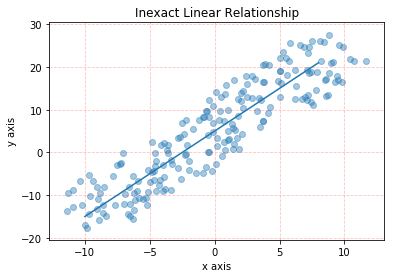

In [3]:
# Create a function that adds some noise to our data
def add_noise(x,y):
    x = x.copy()
    y = y.copy()
    for i in range(len(x)-1):
        boolean = random.randint(0,1)
        if boolean % 2 == 0:
            x[i] = x[i] + random.randint(0,3)
            y[i] = y[i] - random.randint(0,3)
        else:
            x[i] = x[i] - random.randint(0,3)
            y[i] = y[i] + random.randint(0,3)
    return x,y

# Create the data to plot
x2,y2 = add_noise(np.arange(-10,10,.1),\
                  2*np.arange(-10,10,.1) + 5)
x = np.arange(-10,10,2)
y = 2*x + 5

# Plot
plt.plot(x,y,label = 'y = 2*x + 5')
plt.scatter(x2,y2,alpha = .4)
plt.grid(alpha=.25,c='r',ls='--')
plt.title('Inexact Linear Relationship')
plt.xlabel('x axis')
plt.ylabel('y axis');

## The Linear Regression Model:

Linear Regression models the **Expected value** of the outcome, conditional on features

$$ E[y|x] = X^T\beta $$

or

$$ y_i = x_i^T \beta + \epsilon_i $$

This means 

$$ y = \beta_1 * x_1 + \beta_2 * x_2 + ... + \beta_n * x_n + \epsilon $$

- The Epsilon term here is very important!

### Lets see an example!

Assume we have 3 features: Engine Size, Number of tires, and Car weight
- We are trying to predict MPG

|Engine Size|Number of Tires|Car Weight|
|-----------|---------------|----------|
|1500|4|3000|
|2500|6|5000|
|1000|2|1200|
|3000|4|6000|

We could then say that our $\beta$ values are:
- $\beta \space EngineSize$ = -.000025
- $\beta \space NumberTires$ = 3.113
- $\beta \space Car weight$ = -.0003

Then to get the predicted value for each car in the table, we would multiply $x^T$ by the vector for our $\beta$ values

In [4]:
d = {"Engine Size":[1500,2500,1000,3000],\
     "Number of Tires":[4,6,2,4],\
     "Weight":[3000,5000,1200,6000]}

data = pd.DataFrame.from_dict(d)
betas = np.array([-.000025,3.113,-.0003])

print(data)
print(betas)

   Engine Size  Number of Tires  Weight
0         1500                4    3000
1         2500                6    5000
2         1000                2    1200
3         3000                4    6000
[-2.500e-05  3.113e+00 -3.000e-04]


In [5]:
data, betas

(   Engine Size  Number of Tires  Weight
 0         1500                4    3000
 1         2500                6    5000
 2         1000                2    1200
 3         3000                4    6000,
 array([-2.500e-05,  3.113e+00, -3.000e-04]))

In [5]:
print(data.values * betas)
print()
print(np.sum(data.values * betas,axis = 1))

[[-0.0375 12.452  -0.9   ]
 [-0.0625 18.678  -1.5   ]
 [-0.025   6.226  -0.36  ]
 [-0.075  12.452  -1.8   ]]

[11.5145 17.1155  5.841  10.577 ]


In [6]:
d = {}
for i,car in enumerate(np.dot(data,betas)):
    d['Car '+str(i)] = car
d

{'Car 0': 11.5145,
 'Car 1': 17.1155,
 'Car 2': 5.840999999999999,
 'Car 3': 10.577}

In [7]:
np.dot(data,betas)

array([11.5145, 17.1155,  5.841 , 10.577 ])

- Linear Regression Predicts the mean value of y holding x constant
- Model is _linear_ in parameters $\beta$ but features may be **non-linear** functions of the date (e.g. polynomials)

## Notation & Vocabulary Break

### Notation
- y = label = outcome = target = dependent variable = regressand = LHS variable
- x(s) = feature(s) = covariate(s) = input(s) = independent variable(s) = regressor = RHS variable(s)
- Train = Learn = Estimate = Fit a Model


### Vocab:
- N: Number of observations
- K: Number of covariates
- $y_i$: Dependent Variable for observation $i$
- $x_i$: K x 1 vector of Covariates for observation $i$
- $\epsilon_i$ unobserved error for observation $i$
- y: N x 1 vector of $y_i$
- X: N x K matrix of covariates, where each row is $x_i^T$
- $\epsilon$: N x 1 vector of $\epsilon_i$

$$y = X \beta + \epsilon$$

## So how do we find the best line for the data?  

- Lets explore different ways to visualize data and find the best fit line!

### Steps:
1. Load in the Data
2. Use EDA and visualize our features
3. Identify how to model our data

In [7]:
cars = pd.read_csv('data/cars_multivariate.csv')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [8]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [9]:
cars.describe()

,mpg,cylinders,displacement,weight,acceleration,model,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


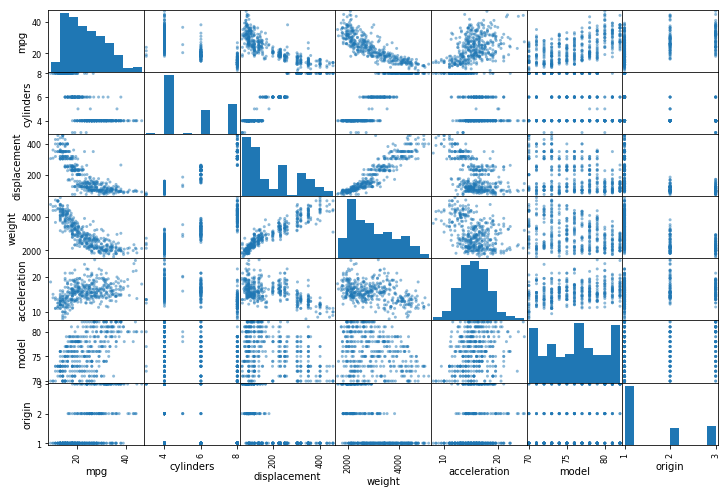

In [10]:
pd.plotting.scatter_matrix(cars, figsize=(12,8));

## Linear Regression

What is it? We are hypothesizing a **linear relationship** between a *target* (or 'endogenous' variable) and some *features* (predictors, or 'exogenous' variables).

In the case of a **single** feature, we are looking to quantify the relationship of the form
$$ y = mx + b $$

Let's select `mpg` as our target and `weight` as our predictor.

First we will start with a 2 dimensional Example

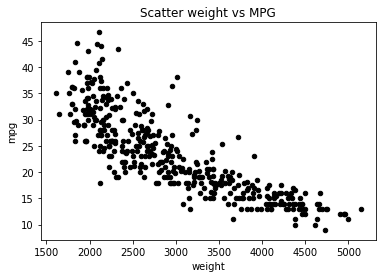

In [11]:
y = cars['mpg']
X = cars['weight']

plt.scatter(X,y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.title('Scatter weight vs MPG')

plt.show()


What is our **Target**?  What is our **Predictor**?

There are lots of lines we could draw -- How do we pick the best one?

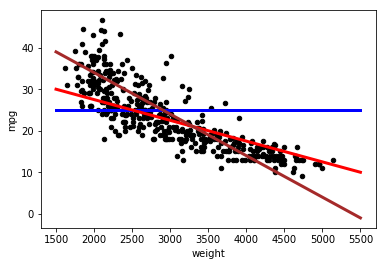

In [12]:
xx = np.linspace(1500,5500)
line0 = 0*xx + 25
line1 = (-1/200)*(xx - 1500) + 30
line2 = (-1/100)*(xx - 1500) + 39

plt.scatter(X,y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.plot(xx, line0, color='b', lw=3)
plt.plot(xx, line1, color='r', lw=3)
plt.plot(xx, line2, color='brown', lw=3);

Let's call our line $\hat{y}$. For any point $x_i$, we have our observed value $y_i$ and our value predicted from our line $$\hat{y}_i = \beta_0 + \beta_1 x_i$$

The *residual* is the distance between our predicted value and the actual value
$$r_i = y_i - \hat{y}_i$$

Let's find the line that minimizes the total **sum of squared residuals** (SSR)
$$ SSR = \sum_{i=1}^N (y_i - \hat{y}_i)^2 $$

SSR for this line: 13084.72088


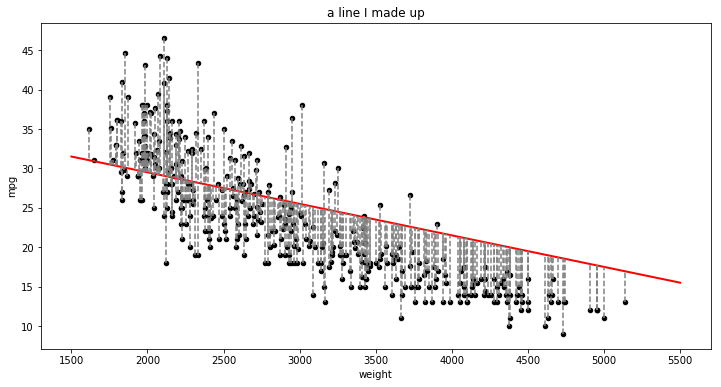

In [13]:
plt.figure(figsize=(12,6))
plt.scatter(X,y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')

b0 = (1500/200) + 30
b1 = (-1/250)

line1 = b0 + b1*xx
plt.plot(xx, line1, color='r', lw=2)

for x_i, y_i in zip(X,y):
    plt.plot([x_i, x_i], [y_i, b1*x_i+b0], color='gray', linestyle='dashed')
    
plt.title("a line I made up")    
    
resids = y - (b0 + b1 * X)
print("SSR for this line: {}".format((resids**2).sum()))

#### Fun exercise: show that the line that minimizes the SSR in the single feature case is

$$ \hat{\beta}_1 = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^N (x_i - \bar{x})^2} = \frac{Cov(x,y)}{Var(x)}$$

$$\beta_0 = \bar{y} - \hat{\beta}_1\bar{x}$$


## Using Stats Models


In [14]:
import statsmodels.api as sm
X.head()

0    3504.0
1    3693.0
2    3436.0
3    3433.0
4    3449.0
Name: weight, dtype: float64

In [15]:
y = cars['mpg']
X = sm.add_constant(cars['weight'])
X.head()

,const,weight
0,1.0,3504.0
1,1.0,3693.0
2,1.0,3436.0
3,1.0,3433.0
4,1.0,3449.0


In [16]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

In [17]:
simple_model = sm.OLS(y, X)
simple_results = simple_model.fit()
simple_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     888.9
Date:                Thu, 07 Feb 2019   Prob (F-statistic):          2.97e-103
Time:                        10:33:23   Log-Likelihood:                -1148.4
No. Observations:                 398   AIC:                             2301.
Df Residuals:                     396   BIC:                             2309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3174      0.795     58.243      0.000      44.754      47.881
weight        -0.0077      0.000    -29.814      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       40.423   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.695
Skew:                           0.713   Prob(JB):                     4.89e-13
Kurtosis:                       4.176   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
type(simple_model)

statsmodels.regression.linear_model.OLS

In [19]:
type(simple_results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [20]:
simple_results.params

const     46.317364
weight    -0.007677
dtype: float64

### Predict for a single data point

In [21]:
simple_results.predict([1,3400])

array([20.2168902])

### Predict for multiple data points

In [24]:
simple_results.predict(sm.add_constant(cars['weight'])).head()

0    19.418523
1    17.967643
2    19.940532
3    19.963562
4    19.840736
dtype: float64

In [25]:
simple_results.fittedvalues.head()

0    19.418523
1    17.967643
2    19.940532
3    19.963562
4    19.840736
dtype: float64

### Draw the line of best fit

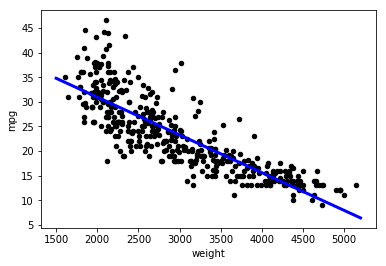

In [26]:
xx = np.linspace(1500,5200)
best_line = simple_results.params['const'] + simple_results.params['weight']*xx

plt.scatter(X['weight'],y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.plot(xx, best_line, color='b', lw=3);

In [27]:
simple_results.predict([1,-20000])

array([199.8495657])

## [This Phet sim is Incredible](https://phet.colorado.edu/sims/html/least-squares-regression/latest/least-squares-regression_en.html)

## What about multiple features?

Assume we have $p$ features.

Then the linear relationship we are assuming has the form
$$ y = \beta_0 + \beta_1* X_1 + \beta_2*X_2 + ... + \beta_p *X_p $$

which we can write as the matrix product
$$Y = X\beta$$
where $Y$ is an $n \times 1$ column vector, $X$ is an $n \times (p+1)$ feature matrix (we've added a column of ones to encode the intercept term), and $\beta$ is a $(p+1) \times 1$ column vector

#### Even more fun exercise
Show that the vector of parameter values $\hat{\beta}$ that minimizes the SSR in the general case is the solution to the matrix equation

 $$ X^T X \hat{\beta} = X^T y $$
 
 Which can also be written as $\hat{\beta} = (X^TX)^{-1}X^Ty$
 

## What is regression in more than one dimension?

Let's plot `mpg` against `weight` and `acceleration`

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


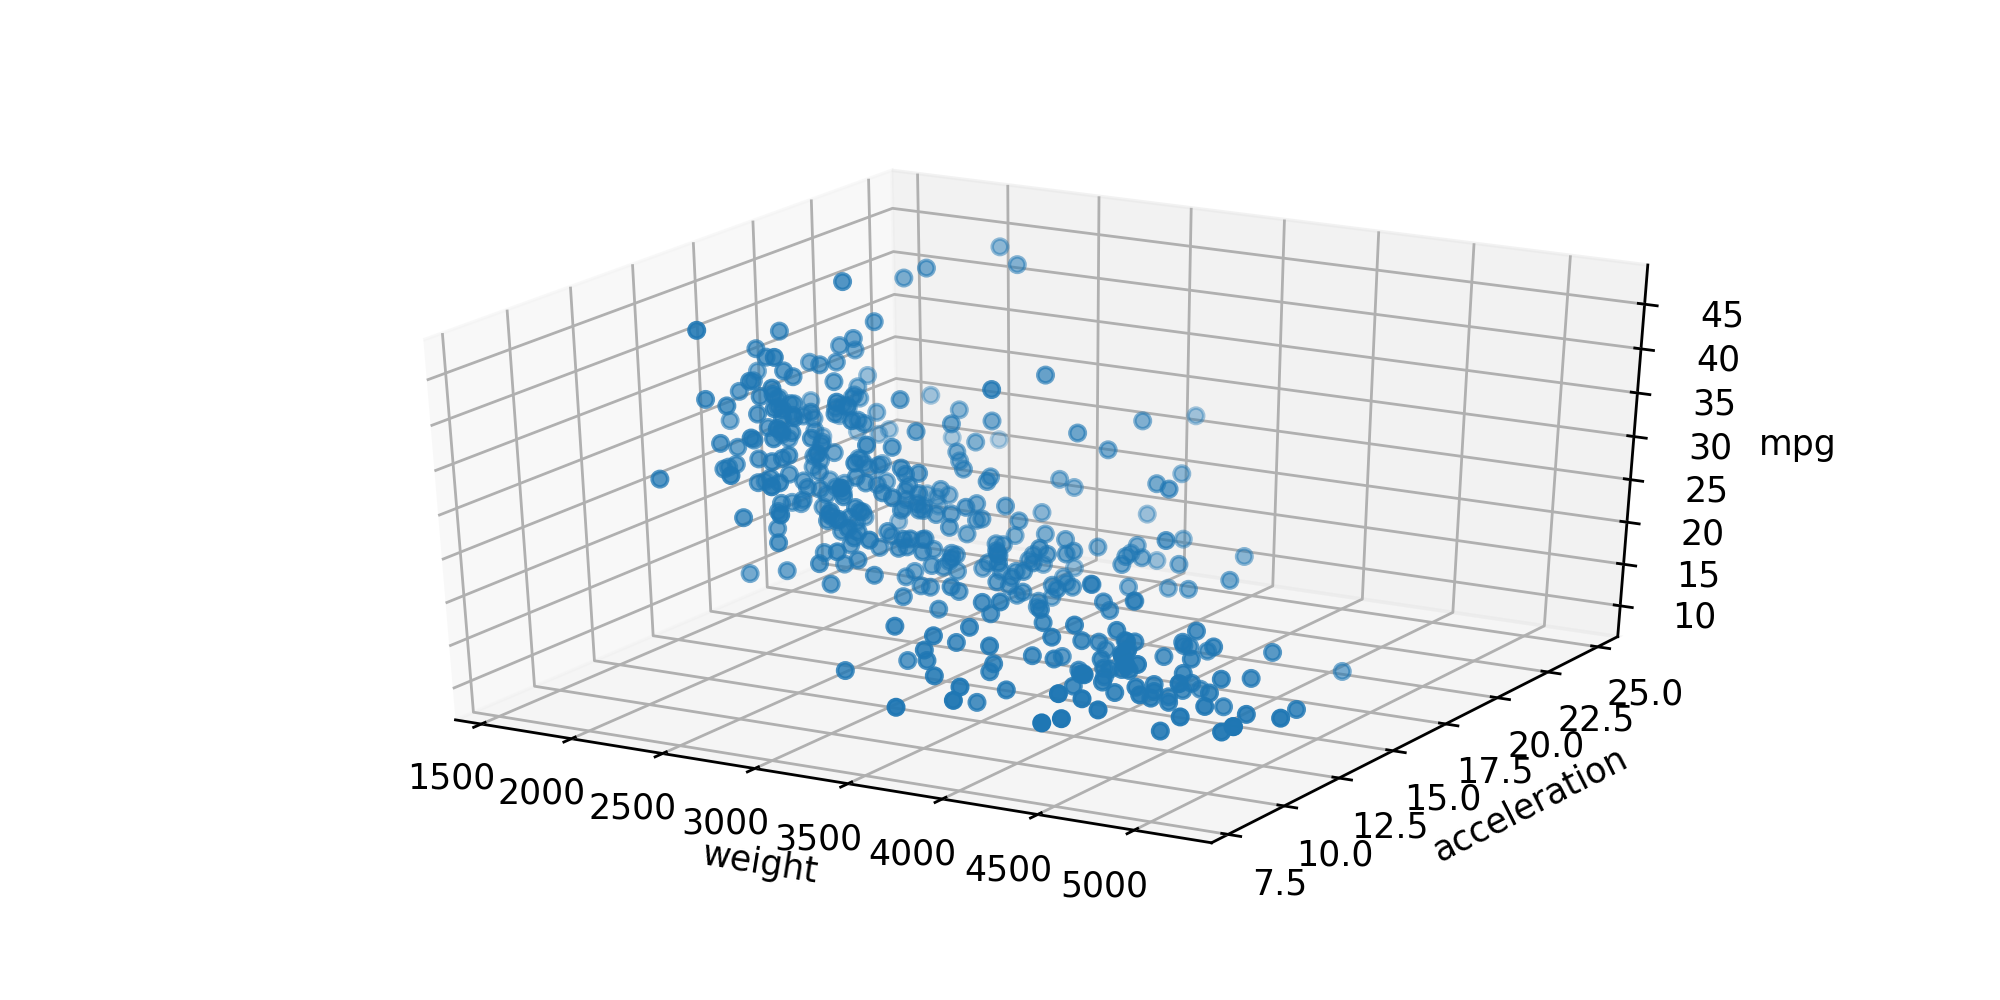

In [29]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cars['weight'], cars['acceleration'], cars['mpg'])
ax.set_zlabel('mpg')
ax.set_xlabel('weight')
ax.set_ylabel('acceleration');

In [30]:
y = cars['mpg']
X = sm.add_constant(cars[['weight','acceleration']])
X.head()

,const,weight,acceleration
0,1.0,3504.0,12.0
1,1.0,3693.0,11.5
2,1.0,3436.0,11.0
3,1.0,3433.0,12.0
4,1.0,3449.0,10.5


In [32]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Thu, 07 Feb 2019   Prob (F-statistic):          1.69e-103
Time:                        10:45:19   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
results.params


const           41.399828
weight          -0.007336
acceleration     0.250816
dtype: float64

<IPython.core.display.Javascript object>


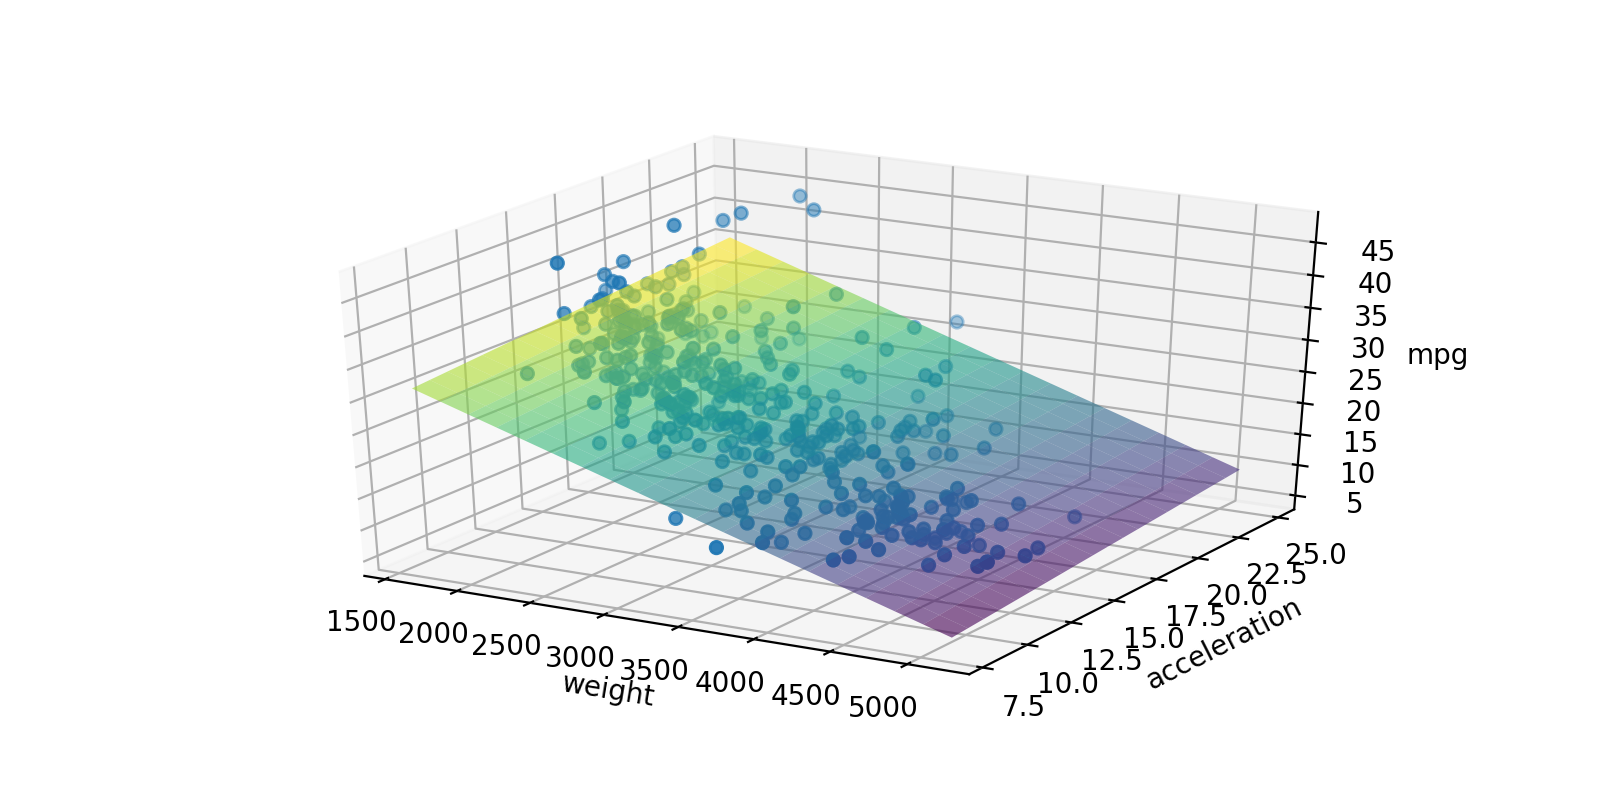

In [34]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cars['weight'], cars['acceleration'], cars['mpg']);
ax.set_zlabel('mpg')
ax.set_xlabel('weight')
ax.set_ylabel('acceleration');

xx1 = np.linspace(cars['weight'].min(), cars['weight'].max(), 20)
xx2 = np.linspace(cars['acceleration'].min(), cars['acceleration'].max(), 20)
xx1, xx2 = np.meshgrid(xx1, xx2)
best_plane = (results.params['const'] +
              results.params['weight']*xx1 +
              results.params['acceleration']*xx2)

# Plot the surface.
surf = ax.plot_surface(xx1, xx2, best_plane, color='k', alpha=.6, cmap='viridis')

## What was all that other stuff in the summary?

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Thu, 07 Feb 2019   Prob (F-statistic):          1.69e-103
Time:                        10:46:06   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## $R^2$ : The "proportion of variance explained"

Let's for a moment refer to the variance of $y$ as "the total sum of squares"
$$ SST = \sum_i^N (y_i - \bar{y})^2 $$

Then we define $R^2$ as the percentage of that variance that has been "captured" by the regression line
$$
\begin{align}
    R^2 &:= 1 - \frac{SSR}{SST} \\
    &= 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
\end{align}    
$$

## P-Values? Confidence intervals? WHAT'S GOING ON

It turns out we don't just want to solve an optimization problem.

We want to make **statistical claims** about this linear relationship. In order to do that, we need to assume a distribution, so here we go.

$$ y = \beta X + \epsilon $$
where
$$ \epsilon \sim Normal(0, \sigma^2) $$

Equivalently, we can write
$$ y \sim Normal(\beta X, \sigma^2) $$

With some work, you can show the following:
 - Given a set of $N$ observations $\{(x_i, y_i)\}$, where $x_i$ is a $p$-dimensional vector, the maximum likelihood estimate for $\beta$ is the same as the least-squares estimate: 
 
 $$\hat{\beta} = (X^TX)^{-1}X^Ty$$
 
 so our model is $\hat{y} = \hat{\beta}X$
 
 
 - The sampling distribution of $\beta$ is: $$ \hat{\beta} \sim Normal(\beta, (X^T X)^{-1}\sigma^2)$$
 
 
 - The unbiased estimate of $\sigma^2$ is $$\hat{\sigma}^2 = \frac{SSR}{N-p} = \frac{\sum_i^N(y_i - \hat{y}_i)^2}{N-p}$$
   - using this estimate, we can construct confidence bounds on our parameters using the student's t distribution: $$ \hat{\beta}_j \, \pm t_{N-p} \sqrt{(X^T X)^{-1}_{jj}\frac{SSR}{N-p}}$$

Now all our null hypotheses have the form "Does $\beta_i = 0$ ?"

###### References:
- [ISLR 3.1.2](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf)
- [here](http://home.cc.umanitoba.ca/~godwinrt/4042/material/part3.pdf)
- [here](http://www.stat.cmu.edu/~hseltman/309/Book/chapter9.pdf)

## Coffee Break!  How is everyone feeling?

## What assumptions must hold in order to make these statistical statements?
Test your assumptions by **plotting your residuals**: $y_{actual} - y_{predicted}$

It is useful to plot your residuals against various features as well as plotting residuals vs predicted y-values.

### Linearity: violated when you see nonlinear trends in your data /  residuals

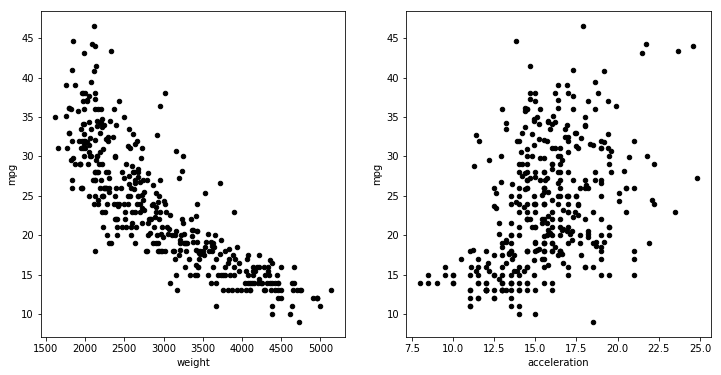

In [37]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].scatter(X['weight'],y, color='k', s=20)
axs[0].set_xlabel('weight')
axs[0].set_ylabel('mpg')

axs[1].scatter(X['acceleration'],y, color='k', s=20)
axs[1].set_xlabel('acceleration')
axs[1].set_ylabel('mpg');

### Lets take a look at our residuals once we have fitted the model

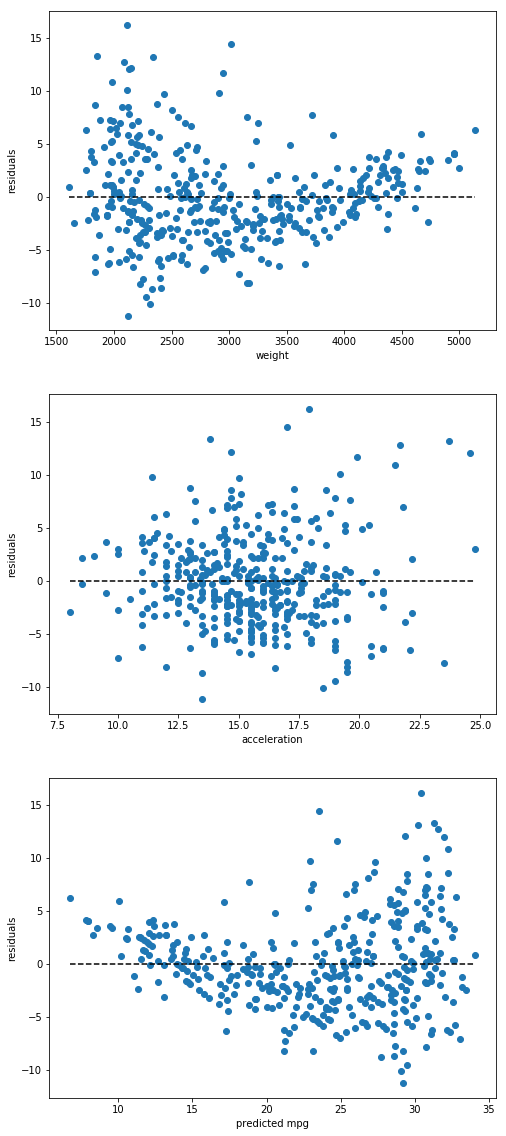

In [38]:
fig, axs = plt.subplots(3,1, figsize=(8,20))

axs[0].scatter(X['weight'], results.resid)
axs[0].hlines(0,
              X['weight'].min(), 
              X['weight'].max(), 
              'k', linestyle='dashed')
axs[0].set_xlabel('weight')
axs[0].set_ylabel('residuals');

axs[1].scatter(X['acceleration'], results.resid)
axs[1].hlines(0,
              X['acceleration'].min(), 
              X['acceleration'].max(), 
              'k', linestyle='dashed')
axs[1].set_xlabel('acceleration')
axs[1].set_ylabel('residuals');

axs[2].scatter(results.fittedvalues, results.resid)
axs[2].hlines(0,
              results.fittedvalues.min(), 
              results.fittedvalues.max(),
              'k', linestyle='dashed')
axs[2].set_xlabel('predicted mpg')
axs[2].set_ylabel('residuals');

### Guiding questions:
- Which residuals look good?
- Which residuals look bad?

Most of the time we want to work with the studentized residuals: divide the residual by the estimate of the standard deviation of the residuals (which turns out to depend on $X$, even though $\epsilon$ above does not depend on $X$. More details [here](https://en.wikipedia.org/wiki/Studentized_residual))

# Normalized Residuals

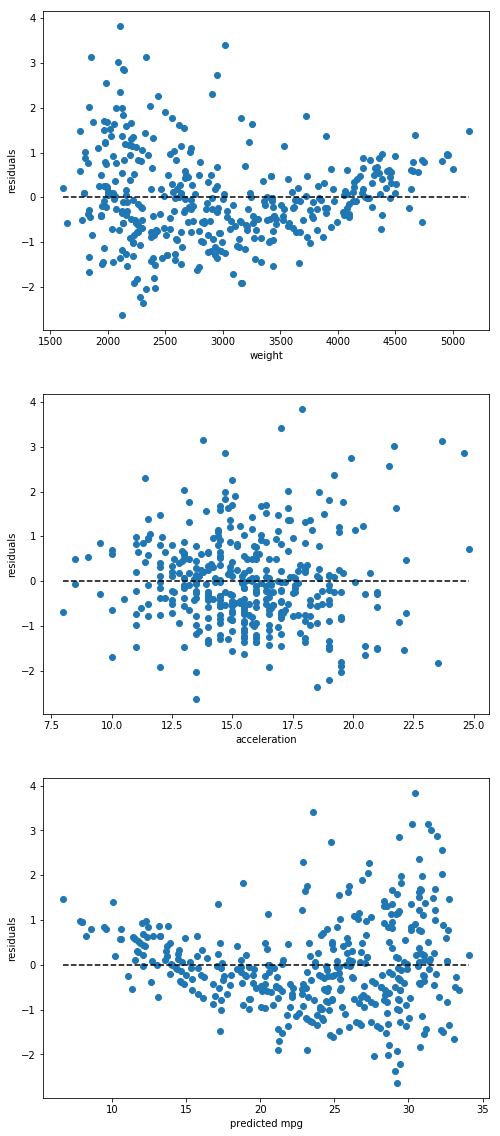

In [39]:
stud_resids = results.outlier_test()['student_resid']

fig, axs = plt.subplots(3,1, figsize=(8,20))

axs[0].scatter(X['weight'], stud_resids)
axs[0].hlines(0,
              X['weight'].min(), 
              X['weight'].max(), 
              'k', linestyle='dashed')
axs[0].set_xlabel('weight')
axs[0].set_ylabel('residuals');

axs[1].scatter(X['acceleration'], stud_resids)
axs[1].hlines(0,
              X['acceleration'].min(), 
              X['acceleration'].max(), 
              'k', linestyle='dashed')
axs[1].set_xlabel('acceleration')
axs[1].set_ylabel('residuals');

axs[2].scatter(results.fittedvalues, stud_resids)
axs[2].hlines(0,
              results.fittedvalues.min(), 
              results.fittedvalues.max(),
              'k', linestyle='dashed')
axs[2].set_xlabel('predicted mpg')
axs[2].set_ylabel('residuals');

# Need Mo Help
### Homoscedasticity: violated when the variance of your residuals isn't constant

- [Homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity)
- [Heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity)

There's a hypothesis test for this, the Goldfeld-Quandt test. It divides your data into two subsets and returns the p-value under the null hypothesis of homoscedasticity. Low p => reject null => Heteroscedastic

How you split the data in half is arbitrary. Usually, you pick a feature and sort the data by that feature, then split on the median value of that feature. 

In [40]:
X.head()

,const,weight,acceleration
0,1.0,3504.0,12.0
1,1.0,3693.0,11.5
2,1.0,3436.0,11.0
3,1.0,3433.0,12.0
4,1.0,3449.0,10.5


- in `statsmodels.stats.diagnostic.het_goldfeldquandt`, specify the column to use for sorting & splitting data with the parameter `idx`.
  - if you leave it blank, the data will be split just by the order it appears in your data set, which is WAY TOO ARBITRARY
- the default alternative hypothesis is "increasing", meaning it does a one-sided test. pick `alternative='two-sided'` to do a two-tailed test, unless you have a very good reason for assuming the direction of variation change.

In [41]:
f_statistic, p_value, _ = sm.stats.diagnostic.het_goldfeldquandt(y, X, idx=1, alternative='two-sided')
print(p_value)

1.835257415566887e-11


Pretty small p-val. Reject the null. Houston, we have heteroscedasticity.

Take away: Can't trust our parameter P values as much

### Normality: violated when the residuals are not normally distributed

The tools for this are the [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) and the [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) (the null hypothesis for the JB test is "the residuals come from a distribution with zero skewness and zero excess kurtosis", which are both properties of the normal distribution).

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Mon, 04 Feb 2019   Prob (F-statistic):          1.69e-103
Time:                        13:45:41   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The QQ plot puts the *empirical sample quantiles* of the residuals on the y-axis and the *theoretical normal distribution quantiles* on the x-axis. 

For example, say one of the studentized residuals has the value $-1.54$. And perhaps we found that $3.51\%$ of the studentized residuals had a value of $-1.54$ or lower. However, if they had been drawn from a normal distribution, we would expect $3.51\%$ of the residuals to fall at or below the value $-1.81$ instead, so this would show up on the QQ plot as the point $(-1.81,-1.54)$.

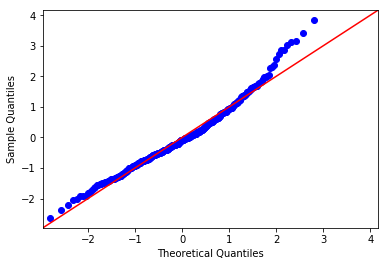

In [43]:
ax = sm.graphics.qqplot(stud_resids, line='45')

### Multicollinearity: strictly violated when one feature is a linear combination of others, loosely violated when one feature is highly correlated with others

- Betas are less interpretable

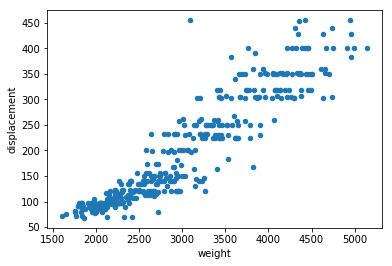

In [44]:
cars.plot.scatter('weight','displacement');

In [45]:
y = cars['mpg']
X = sm.add_constant(cars[['weight','acceleration']])
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Mon, 04 Feb 2019   Prob (F-statistic):          1.69e-103
Time:                        13:46:33   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# What are we looking at here?

In [46]:
y = cars['mpg']
X = sm.add_constant(cars[['weight','acceleration', 'displacement']])
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     307.0
Date:                Mon, 04 Feb 2019   Prob (F-statistic):          1.01e-102
Time:                        13:46:44   Log-Likelihood:                -1142.7
No. Observations:                 398   AIC:                             2293.
Df Residuals:                     394   BIC:                             2309.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.2991      1.861     22.186      0.000      37.639      44.959
weight          -0.0062      0.001     -8.368      0.000      -0.008      -0.005
acceleration     0.1739      0.098      1.783      0.075      -0.018       0.366
displacement    -0.0109      0.007     -1.675      0.095      -0.024       0.002
==============================================================================
Omnibus:                       36.015   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.328
Skew:                           0.681   Prob(JB):                     5.28e-11
Kurtosis:                       4.000   Cond. No.                     2.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

One measure of multicollinearity: the Variance Inflation Factor. Regress feature $X_k$ on all the rest of the features and get the $R^2$ value for that fit.

$$VIF_k = \frac{1}{1 - R_k^2}$$

Rule of thumb: collinearity is high if VIF > 10

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
variance_inflation_factor(X.values, 1)

8.444839059378735